In [44]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [45]:
batch_size = 256

nz = 100 
ngf = 32 
ngpu = 1

niter = 3

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [46]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [47]:
def get_target_and_mask(target_label):
    """
    Args:
    
    Returns:
    
    """
    
    t = torch.zeros(10)
    t[target_label] = 1.0
    
    return t.to(device) 

In [48]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(train_data)

60000

In [49]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

In [50]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


### Load EMNIST

In [51]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.zip")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

/tmp/ipykernel_110137/58620865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]


## DCGAN Model

In [52]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [53]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
#netG.load_state_dict(torch.load('weights/netG_epoch_99.pth'))
print(netG)

Number of parameters: 3,573,696
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bia

In [55]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, 2, 1, 1, bias=False),
            # nn.BatchNorm2d(1),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(1, 1, 2, 2, 0, bias=False),
            # nn.BatchNorm2d(1),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(1, 1, 2, 2, 0, bias=False),
            # nn.BatchNorm2d(1),
            nn.Flatten(),
            #FuzzyLayer.from_dimensions(9, 10),
            #nn.Linear(9, 2),
            #nn.BatchNorm1d(2),
            #DefuzzyLinearLayer.from_dimensions(100, 1, with_norm=False)
            
            #DefuzzyLinearLayer.from_dimensions(20, 1, with_norm=False)
            #nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            #nn.Sigmoid()
        )
        self.latent_dim = 16
        self.fuzzlets = 1
        self.real = nn.Sequential(
            FuzzyLayer.from_dimensions(self.latent_dim, self.fuzzlets)
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            r = nn.parallel.data_parallel(self.real, output, range(self.ngpu))
        else:
            output = self.main(input)
            r = self.real(output)

        centroids = self.real[0].A[:,:,-1][r.max(1).indices]
        
        return r.squeeze(), (output + centroids).abs().sum(-1)
    
    def arate(self, input):
        return self.forward(input)[0]
    

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

Number of parameters: 658,448
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (real): Sequential(
    (0): FuzzyLayer()
  )
)


In [56]:
inp = torch.rand(10, 1, 28, 28)
dd = Discriminator(1)
dd(inp)

(tensor([0.0205, 0.0303, 0.0366, 0.0332, 0.0256, 0.0330, 0.0441, 0.0449, 0.0218,
         0.0307], grad_fn=<SqueezeBackward0>),
 tensor([12.5813, 11.1214, 10.4095, 11.4799, 12.1971, 11.3510, 10.5210,  9.7799,
         11.8525, 11.4274], grad_fn=<SumBackward1>))

In [13]:
output = dd.main(inp)
r = dd.real(output)
centroids = dd.real[0].A[:,:,-1][r.max(1).indices]        

r.max(1).indices

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Train

In [14]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [15]:
def criterionDReal(predicted, dists):
    #clamped = torch.clamp(predicted, 0.0, 0.2)
    return torch.square(predicted - 1).mean() + dists.mean()

def criterionDFake(predicted, dists):
    #clamped = torch.clamp(predicted, 0.2, 1.0)
    return torch.square(predicted).mean() + dists.mean()
    
def criterionG(predicted, dists):
    return dists.mean() #-cap_g.log().max()
         #+ torch.square(predicted[:, fake_label] - 0.5).mean()#-torch.clamp(predicted, 0.0, 1.0).log().max()

In [16]:
def get_test_arate_distr(D):
    firing_levels = []
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc='Test MNIST'):
            data = data.view((-1,1,28,28)).to(device)
            rates = D.arate(data)
            firing_levels.append(rates.cpu().numpy())
            

    firing_levels = np.concatenate(firing_levels, axis=0)
    for p in firing_levels:
        lab_true.append(1)
        lab_pred.append(p)

    with torch.no_grad():
        for data, labels in tqdm(emnist_loader, desc='Test EMNIST'):
            data = data.view((-1, 1, 28, 28)).to(device) 
            arate = D.arate(data)
            
            for p in arate.cpu().numpy():
                lab_true.append(0)
                lab_pred.append(p)
                
    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)

    return firing_levels, roc_auc

In [17]:
for epoch in range(niter):

    netG.train()
    netD.train()
    report_loss_G = 0
    report_loss_D = 0
    report_loss_D_dist = 0
    local_count = 0
    for i, data in enumerate(tqdm(train_loader, desc='Training')):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        
        batch_size = real_cpu.size(0)
        output, dists_r = netD(real_cpu)
        errD_real = criterionDReal(output, dists_r)
        errD_real.backward()
        
        #D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output, dists_f = netD(fake.detach())
        errD_fake = criterionDFake(output, dists_f)
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        #torch.nn.utils.clip_grad_norm_(netD.parameters(), 1)
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        output, dists_g = netD(fake)
        errG = criterionG(output, dists_g)
        errG.backward()
        #D_G_z2 = output.mean().item()
        #torch.nn.utils.clip_grad_norm_(netG.parameters(), 1)
        optimizerG.step()
        report_loss_G += errG.item()

        local_count += 1
        report_loss_D += errD.item()
        report_loss_D_dist += dists_r.mean().item()+dists_f.mean().item()+dists_g.mean().item()
        
        
    netG.eval()
    netD.eval()

    losses = {}
    
    losses['dist'] = report_loss_D_dist / local_count
    losses['D'] = report_loss_D / local_count
    losses['G'] = report_loss_G / local_count
    writer.add_scalars('Loss', losses, epoch)
    fake = netG(fixed_noise)
    writer.add_images('Generated images', fake.detach(), epoch)
    mnist_distr, auc = get_test_arate_distr(netD)
    mnist_distr_q = {}
    mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
    mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
    writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
    writer.add_scalar("AUC", auc, epoch)
    print(f"Epoch {epoch}/{niter}")

    
num_gpu = 1 if torch.cuda.is_available() else 0

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 0/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 1/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 2/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 3/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 4/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 5/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 6/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 7/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 8/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 9/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 10/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 11/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 12/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 13/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 14/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 15/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 16/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 17/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 18/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 19/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 20/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 21/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 22/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 23/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 24/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 25/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 26/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 27/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 28/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 29/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 30/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 31/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 32/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 33/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 34/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 35/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 36/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 37/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 38/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 39/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 40/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 41/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 42/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 43/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 44/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 45/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 46/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 47/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 48/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 49/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 50/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 51/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 52/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 53/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 54/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 55/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 56/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 57/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 58/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 59/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 60/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 61/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 62/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 63/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 64/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 65/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 66/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 67/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 68/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 69/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 70/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 71/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 72/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 73/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 74/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 75/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 76/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 77/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 78/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 79/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 80/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 81/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 82/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 83/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 84/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 85/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 86/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 87/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 88/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 89/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 90/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 91/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 92/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 93/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 94/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 95/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 96/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 97/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 98/100


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Test MNIST:   0%|          | 0/40 [00:00<?, ?it/s]

Test EMNIST:   0%|          | 0/405 [00:00<?, ?it/s]

Epoch 99/100


## Валидация

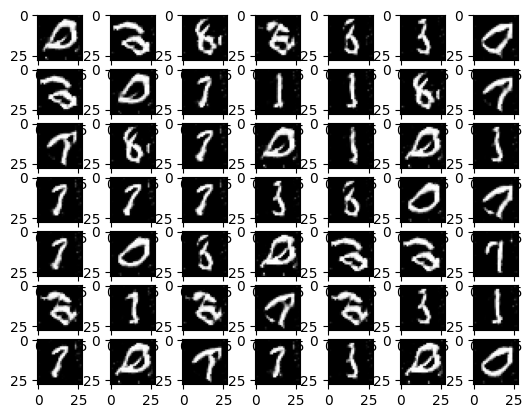

In [28]:
D = netD
G = netG
D.eval()
G.eval()

batch_size = 49
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 7, 7
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()

In [29]:
centroids_fz = -D.real[0].A[:,:,-1].cpu().detach().numpy()
centroids_fz

array([[-1.6375583 ,  0.9198592 , -0.17467648,  1.3111061 ,  1.2193311 ,
         0.5243351 ,  0.50979865, -0.04427215, -0.8490189 ,  1.3426859 ,
        -2.1677034 , -0.34410328, -0.7758737 ,  0.5004542 ,  0.3922907 ,
         1.9753841 ]], dtype=float32)

Encoding:   0%|          | 0/235 [00:00<?, ?it/s]

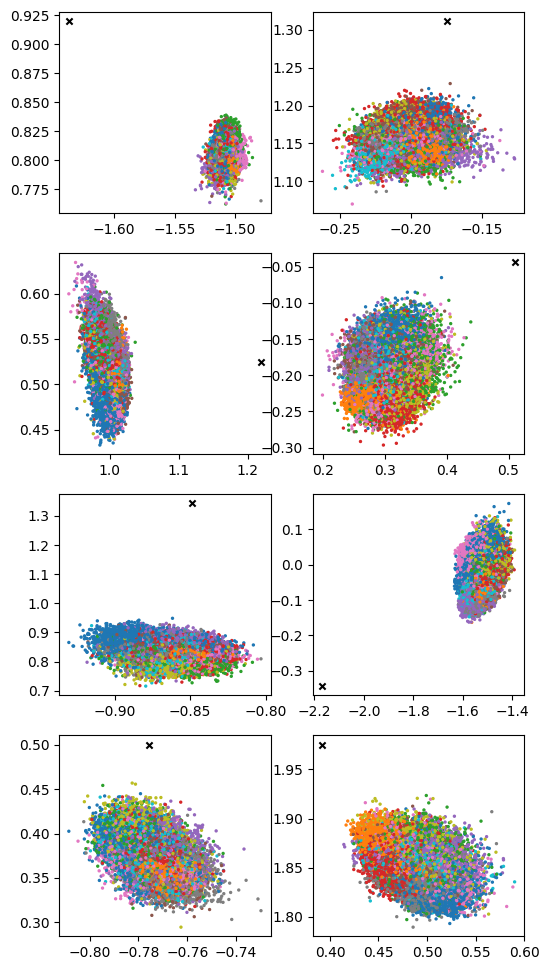

In [30]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(6, 12))

R, C = 4, 2
cnt = 1
for i in range(8):
    plt.subplot(R, C, cnt)
    cnt += 1
    plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
    plt.scatter(centroids_fz[:,2*i], centroids_fz[:,2*i+1], marker='x', c='black', s= 20)
#plt.colorbar()
plt.show()



Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

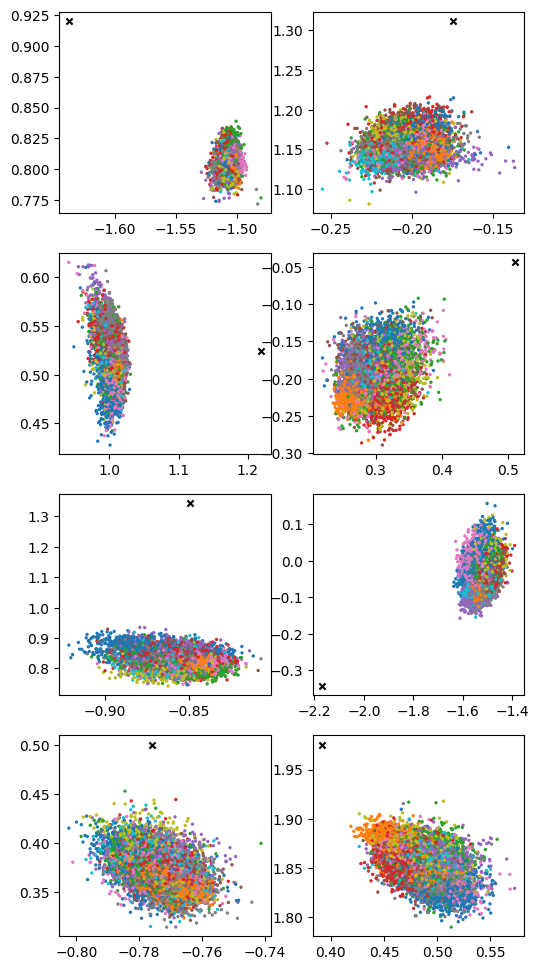

In [31]:
embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)
plt.figure(figsize=(6, 12))

R, C = 4, 2
cnt = 1
for i in range(8):
    plt.subplot(R, C, cnt)
    cnt += 1
    plt.scatter(embedings[:, 2*i], embedings[:, 2*i+1], c=labels_expected, cmap='tab10', s=2)
    plt.scatter(centroids_fz[:,2*i], centroids_fz[:,2*i+1], marker='x', c='black', s= 20)
#plt.colorbar()
plt.show()



In [32]:
embedings

array([[-1.5093503 ,  0.8096293 , -0.2252633 , ...,  0.36990255,
         0.491328  ,  1.8205779 ],
       [-1.5025243 ,  0.8193497 , -0.2162948 , ...,  0.3768464 ,
         0.48212245,  1.8664374 ],
       [-1.5017152 ,  0.81012475, -0.19239172, ...,  0.36004347,
         0.4695713 ,  1.8546783 ],
       ...,
       [-1.5035844 ,  0.8069386 , -0.20304103, ...,  0.39765364,
         0.4869929 ,  1.8523483 ],
       [-1.5071126 ,  0.7961983 , -0.20481001, ...,  0.374397  ,
         0.4722722 ,  1.8771306 ],
       [-1.5135791 ,  0.81063247, -0.19201353, ...,  0.39029685,
         0.5334948 ,  1.8320407 ]], dtype=float32)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

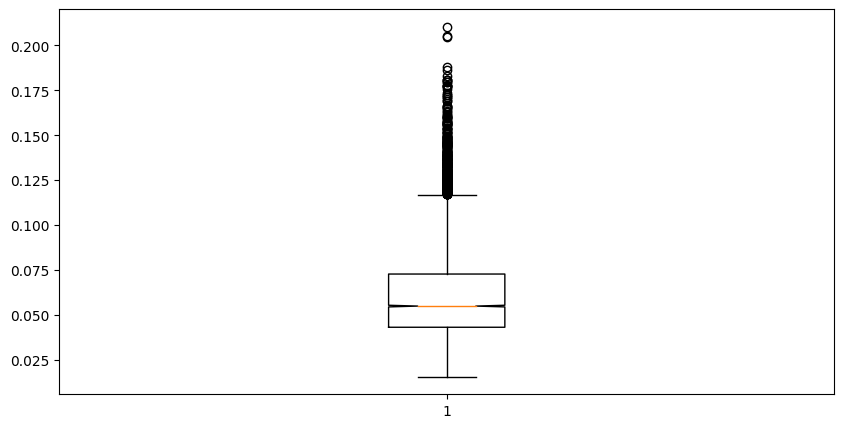

In [33]:
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        rates = D.arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #rates = r

        firing_levels.append(rates.cpu().numpy())
        
firing_levels = np.concatenate(firing_levels, axis=0)
fig = plt.figure(figsize =(10, 5))
plt.boxplot(firing_levels, notch=True, showfliers=True)
plt.show()

In [34]:
firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = D.arate(data)
        #output = D.main(data)
        #r = D.real(output)
        #arate = 1 - r.sum(dim = 1)
        
        for label, flabel in zip(labels, arate.cpu().numpy()):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

Encoding:   0%|          | 0/405 [00:00<?, ?it/s]

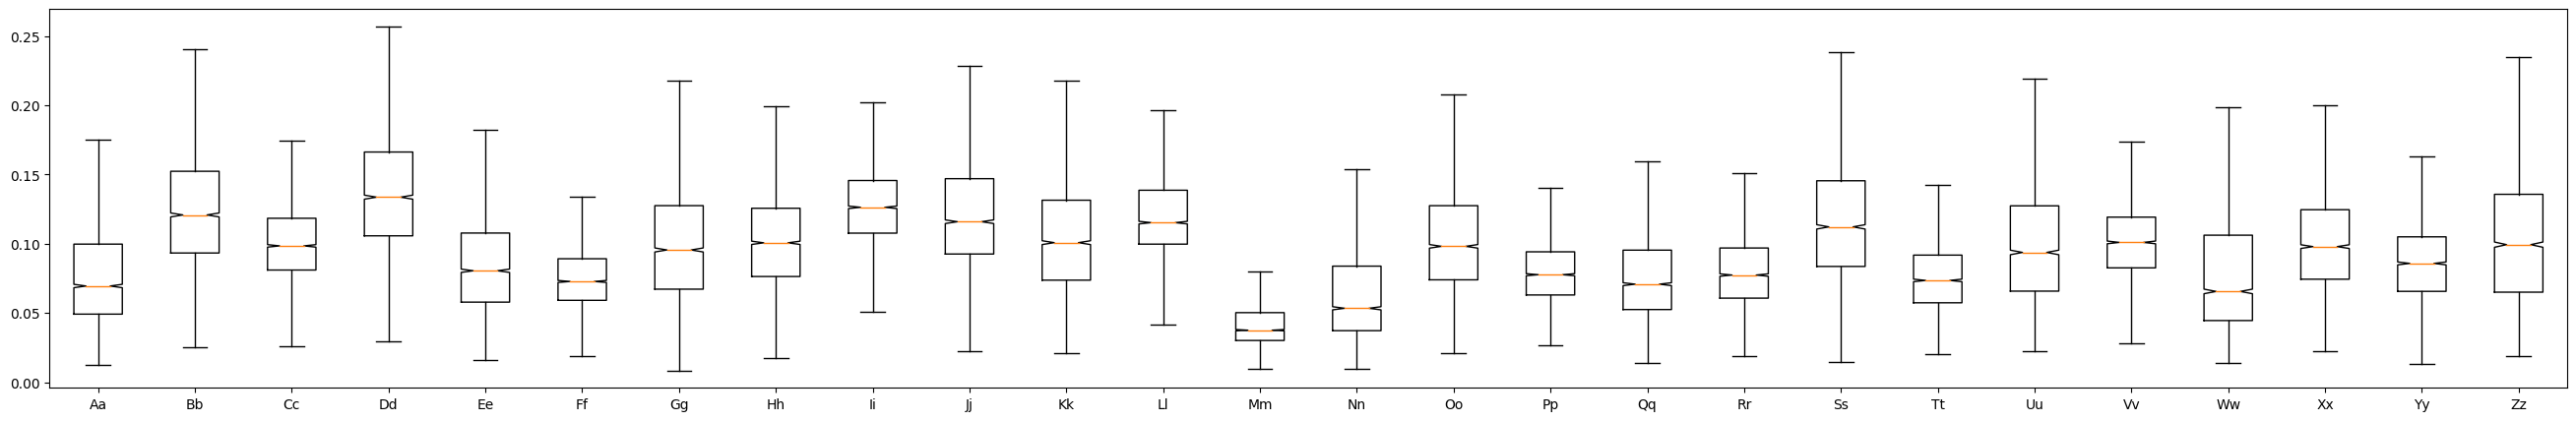

In [35]:
labels, data = firings_emnist.keys(), firings_emnist.values()
fig = plt.figure(figsize =(33, 5))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

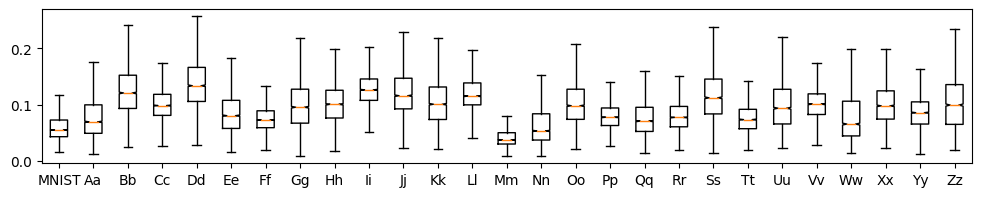

In [36]:
firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(12, 2))
#plt.ylim(ymin=0)
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

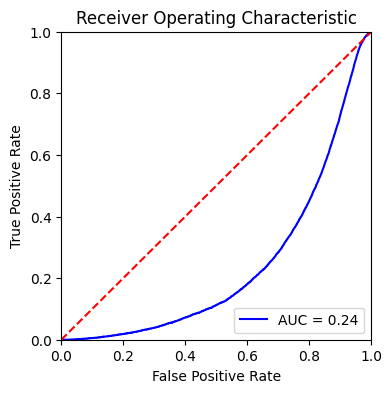

In [37]:
lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    if k == 'Oo':
        continue
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize =(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
writer.add_figure('ROC', fig)